# Schedtune.prefer_idle experiment

This notebook demonstrates the workload behaviour for different schedtune.prefer_idle setting

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)
# Comment the follwing line to disable devlib debugging statements
# logging.getLogger('ssh').setLevel(logging.DEBUG)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import subprocess

# Support to access the remote target
import devlib
from env import TestEnv

# Support for trace events analysis
from trace import Trace
from trace_analysis import TraceAnalysis

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test environment setup

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'android',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',   # load JUNO specific settings, e.g.
                              # - HWMON based energy sampling
                              # - Juno energy model
                              # valid options are:
                              # - juno  - JUNO Development Board
                              # - tc2   - TC2 Development Board
                              # - oak   - Mediatek MT63xx based target

    # Define devlib module to load
    #"modules"     : [
    #    'bl',           # enable big.LITTLE support
    #    'cpufreq'       # enable CPUFreq support
    #],

    # Account to access the remote target
    "host"        : '10.169.36.25',
    "username"    : 'root',
    "password"    : '',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
    
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['rt-app', 'taskset', 'trace-cmd'],
    
    # FTrace events end buffer configuration
    "ftrace"  : {
         "events" : [
            "cpu_frequency",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_switch",
            'dequeue_task_fair', 
            'enqueue_task_fair', 
            'set_next_entity',

                    
            "cpu_capacity",
            "cpu_idle",
            
            #/sys/kernel/debug/tracing/events/sched
            "sched_blocked_reason",
            "sched_boost_cpu",
            "sched_boost_task",
            "sched_contrib_scale_f",
            "sched_cpu_hotplug",
            "sched_energy_diff",
            "sched_kthread_stop",
            "sched_kthread_stop_ret",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_migrate_task",
            "sched_move_numa",
            "sched_pi_setprio",
            "sched_process_exec",
            "sched_process_exit",
            "sched_process_fork",
            "sched_process_free",
            "sched_process_wait",
            "sched_stat_blocked",
            "sched_stat_iowait",
            "sched_stat_runtime",
            "sched_stat_sleep",
            "sched_stat_wait",
            "sched_stick_numa",
            "sched_swap_numa",
            "sched_switch",
            "sched_tune_boostgroup_update",
            "sched_tune_config",
            "sched_tune_tasks_update",
            "sched_tune_filter",
            "sched_wait_task",
            "sched_wake_idle_without_ipi",
            "sched_wakeup",
            "sched_wakeup_new",
            
            
         ],
         "buffsize" : 10240
    },
    "results_dir" : "prefer_idle",
}

In [4]:
# Support to access the remote target
import devlib
from env import TestEnv

# Initialize a test environment using:
# the provided target configuration (my_target_conf)
# the provided test configuration   (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

03:34:29  INFO    :         Target - Using base path: /data/lisa_fork/lisa
03:34:29  INFO    :         Target - Loading custom (inline) target configuration
03:34:29  INFO    :         Target - Loading custom (inline) test configuration
03:34:29  INFO    :         Target - External tools using:
03:34:29  INFO    :         Target -    ANDROID_HOME: /home/zhifei/zyang/android-sdk-linux
03:34:29  INFO    :         Target -    CATAPULT_HOME: /data/lisa_fork/lisa/tools/catapult
03:34:29  INFO    :         Target - Devlib modules to load: ['bl', 'hwmon', 'cpufreq']
03:34:29  INFO    :         Target - Connecting Android target [10.169.36.25:5555]
03:34:29  INFO    :         Target - Connection settings:
03:34:29  INFO    :         Target -    {'device': '10.169.36.25:5555'}
03:34:31  INFO    :         Target - Initializing target workdir:
03:34:31  INFO    :         Target -    /data/local/tmp/devlib-target
03:34:38  INFO    :         Target - Topology:
03:34:38  INFO    :         Target -  

# Workload configuration

In [22]:
# Support to configure and run RTApp based workloads
from wlgen import RTA, Periodic, Ramp

# Create a new RTApp workload generator using the calibration values
# reported by the TestEnv module
rtapp = RTA(target, 'simple', calibration=te.calibration())

# Configure this RTApp instance to:
rtapp.conf(
    # 1. generate a "profile based" set of tasks
    kind='profile',
    
    # 2. define the "profile" of each task
    params={
        
        "period_1" : Periodic(
            period_ms=100,
            duty_cycle_pct=10,
            duration_s=10,
        ).get(),

        "period_2" : Periodic(
            period_ms=100,
            duty_cycle_pct=50,
            duration_s=10,
        ).get(),

                
        "ramp_1" : Ramp(
            start_pct=5,           # intial load
            end_pct=85,            # end load
            delta_pct=20,          # load % increase...
            time_s=1,              # ... every 1 second            
        ).get(),

        "ramp_2" : Ramp(
            start_pct=10,          # intial load
            end_pct=60,            # end load
            delta_pct=5,           # load % increase...
            time_s=1,              # ... every 1 second            
        ).get(),

    },
    
    # 4. use this folder for task logfiles
    run_dir=target.working_directory
    
);

03:39:30  INFO    :          WlGen - Setup new workload simple
03:39:30  DEBUG   :          WlGen - Setup step [postrun] callback to [__postrun] function
03:39:30  DEBUG   :          WlGen - Configuring a profile-based workload...
03:39:30  DEBUG   :          RTApp - ref on big cpu: 1
03:39:30  INFO    :          RTApp - Workload duration defined by longest task
03:39:30  INFO    :          RTApp - Default policy: SCHED_OTHER
03:39:30  INFO    :          RTApp - ------------------------
03:39:30  INFO    :          RTApp - task [period_1], sched: using default policy
03:39:30  INFO    :          RTApp -  | calibration CPU: 1
03:39:30  INFO    :          RTApp -  | loops count: 1
03:39:30  INFO    :          RTApp - + phase_000001: duration 10.000000 [s] (100 loops)
03:39:30  INFO    :          RTApp - |  period   100000 [us], duty_cycle  10 %
03:39:30  INFO    :          RTApp - |  run_time  10000 [us], sleep_time  90000 [us]
03:39:30  INFO    :          RTApp - -----------------------

# Workload execution

In [23]:
# Set Sched governor
#
# For Juno big/LITTLE CPUs
#
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

target.cpufreq.set_all_governors('sched')

logging.info("Target current governor: %s",
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor")
            )
logging.info("Target big CPU max CPUfreq:%s\n\t\t    Target big CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq")
             )

logging.info("Target LITTLE CPU max CPUfreq:%s \n\t\t    Target LITTLE CPU current CPUfreq: %s", 
             target.read_value("/sys/devices/system/cpu/cpu1/cpufreq/scaling_max_freq"),
             target.read_value("/sys/devices/system/cpu/cpu1/cpufreq/scaling_cur_freq")
             )

03:39:33  INFO    : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']
03:39:33  DEBUG   : adb -s 10.169.36.25:5555 shell "echo '/data/local/tmp/bin/shutils cpufreq_set_all_governors sched' | su"
03:39:33  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/sys/devices/system/cpu/cpu0/cpufreq/scaling_governor'"
03:39:33  INFO    : Target current governor: sched
03:39:33  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/sys/devices/system/cpu/cpu0/cpufreq/scaling_max_freq'"
03:39:33  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/sys/devices/system/cpu/cpu0/cpufreq/scaling_cur_freq'"
03:39:33  INFO    : Target big CPU max CPUfreq:850000
		    Target big CPU current CPUfreq: 850000
03:39:33  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/sys/devices/system/cpu/cpu1/cpufreq/scaling_max_freq'"
03:39:33  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/sys/devices/system/cpu/cpu1/cpufreq/scaling_cur_freq'"
03:39:33  INFO    : Target LITTLE CPU max CPUfreq:1100000 
		    Target 

# schedtune.prefer_idle = 0

In [24]:
#
# configure prefer_idle
#
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))
#os.system("uname -a")
#target.execute("ls -al /dev/stune")
target.execute("echo 0 > /dev/stune/schedtune.prefer_idle")
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))

03:39:35  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/dev/stune/schedtune.prefer_idle'"
03:39:35  INFO    : /dev/stune/schedtune.prefer_idle = 0
03:39:35  DEBUG   : adb -s 10.169.36.25:5555 shell "echo 0 > /dev/stune/schedtune.prefer_idle"
03:39:35  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/dev/stune/schedtune.prefer_idle'"
03:39:36  INFO    : /dev/stune/schedtune.prefer_idle = 0


In [25]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
(nrg, nrg_file) = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

03:39:37  INFO    : #### Setup FTrace
03:39:37  DEBUG   : adb -s 10.169.36.25:5555 shell "echo 'echo 10240 > '\\''/sys/kernel/debug/tracing/buffer_size_kb'\\''' | su"
03:39:37  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/sys/kernel/debug/tracing/buffer_size_kb'"
03:39:37  DEBUG   : adb -s 10.169.36.25:5555 shell "echo '/data/local/tmp/bin/trace-cmd reset' | su"
03:39:38  DEBUG   : adb -s 10.169.36.25:5555 shell "echo '/data/local/tmp/bin/trace-cmd start -e cpu_frequency -e sched_load_avg_cpu -e sched_load_avg_task -e sched_switch -e cpu_capacity -e cpu_idle -e sched_blocked_reason -e sched_boost_cpu -e sched_boost_task -e sched_contrib_scale_f -e sched_cpu_hotplug -e sched_energy_diff -e sched_kthread_stop -e sched_kthread_stop_ret -e sched_load_avg_cpu -e sched_load_avg_task -e sched_migrate_task -e sched_move_numa -e sched_pi_setprio -e sched_process_exec -e sched_process_exit -e sched_process_fork -e sched_process_free -e sched_process_wait -e sched_stat_blocked -e sched_stat_io

# Collected results

In [26]:
# All data are produced in the output folder defined by the TestEnv module
logging.info('Content of the output folder %s', te.res_dir)
!ls -la {te.res_dir}

03:40:10  INFO    : Content of the output folder /data/lisa_fork/lisa/results/prefer_idle


total 30312
drwxrwxr-x  2 zhifei zhifei     4096 2月  27 15:39 .
drwxrwxr-x 29 zhifei zhifei     4096 2月  27 15:34 ..
-rw-rw-r--  1 zhifei zhifei    26210 2月  27 15:37 cluster_freqs.png
-rw-rw-r--  1 zhifei zhifei    20962 2月  27 15:38 cpu_idle_state_residency.png
-rw-rw-r--  1 zhifei zhifei       67 2月  27 15:39 energy.json
-rw-rw-r--  1 zhifei zhifei      581 2月  27 15:39 output.log
-rw-rw-r--  1 zhifei zhifei     1075 2月  27 15:39 platform.json
-rw-r--r--  1 zhifei zhifei    12560 2月  27 15:39 rt-app-period_1-0.log
-rw-r--r--  1 zhifei zhifei    12560 2月  27 15:39 rt-app-period_2-1.log
-rw-r--r--  1 zhifei zhifei     6360 2月  27 15:39 rt-app-ramp_1-0.log
-rw-r--r--  1 zhifei zhifei     6360 2月  27 15:39 rt-app-ramp_1-1.log
-rw-r--r--  1 zhifei zhifei     6360 2月  27 15:39 rt-app-ramp_1-2.log
-rw-r--r--  1 zhifei zhifei    13800 2月  27 15:39 rt-app-ramp_2-2.log
-rw-r--r--  1 zhifei zhifei    13800 2月  27 15:39 rt-app-ramp_2-3.log
-rw-r--r--  1 zhifei zhifei    12560 2月  27 15:35 rt-ap

In [27]:
# Inspect the JSON file used to run the application
with open('{}/simple_00.json'.format(te.res_dir), 'r') as fh:
    rtapp_json = json.load(fh, )
logging.info('Generated RTApp JSON file:')
#print json.dumps(rtapp_json, indent=4, sort_keys=True)

03:40:12  INFO    : Generated RTApp JSON file:


In [28]:
# Dump the energy measured for the LITTLE and big clusters
logging.info('Energy: %s', nrg_file)
print json.dumps(nrg, indent=4, sort_keys=True)

03:40:13  INFO    : Energy: /data/lisa_fork/lisa/results/prefer_idle/energy.json


{
    "LITTLE": 1.1401310000000109, 
    "big": 8.007968999999989
}


In [29]:
# Dump the platform descriptor, which could be useful for further analysis
# of the generated results
logging.info('Platform description: %s', plt_file)
#print json.dumps(plt, indent=4, sort_keys=True)

03:40:14  INFO    : Platform description: /data/lisa_fork/lisa/results/prefer_idle/platform.json


# Trace inspection

In [30]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

# Task Behavior

In [31]:
events_to_parse = my_tests_conf['ftrace']['events']

trace = Trace(plt, te.res_dir, events_to_parse)

ftrace = trace.ftrace

trappy.plotter.plot_trace(ftrace, execnames=['period_1', "period_2", 
                                             "ramp_1", "ramp_2",                                             ])

03:40:26  DEBUG   : Loading [sched] events from trace in [/data/lisa_fork/lisa/results/prefer_idle]...
03:40:27  DEBUG   : Parsing events: ['cpu_frequency', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_switch', 'dequeue_task_fair', 'enqueue_task_fair', 'set_next_entity', 'cpu_capacity', 'cpu_idle', 'sched_blocked_reason', 'sched_boost_cpu', 'sched_boost_task', 'sched_contrib_scale_f', 'sched_cpu_hotplug', 'sched_energy_diff', 'sched_kthread_stop', 'sched_kthread_stop_ret', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_migrate_task', 'sched_move_numa', 'sched_pi_setprio', 'sched_process_exec', 'sched_process_exit', 'sched_process_fork', 'sched_process_free', 'sched_process_wait', 'sched_stat_blocked', 'sched_stat_iowait', 'sched_stat_runtime', 'sched_stat_sleep', 'sched_stat_wait', 'sched_stick_numa', 'sched_swap_numa', 'sched_switch', 'sched_tune_boostgroup_update', 'sched_tune_config', 'sched_tune_tasks_update', 'sched_tune_filter', 'sched_wait_task', 'sched_wake_idle_wit

# Analysis

03:40:44  INFO    : ftrace object =<trappy.ftrace.FTrace object at 0x7fc9eefdd1d0>


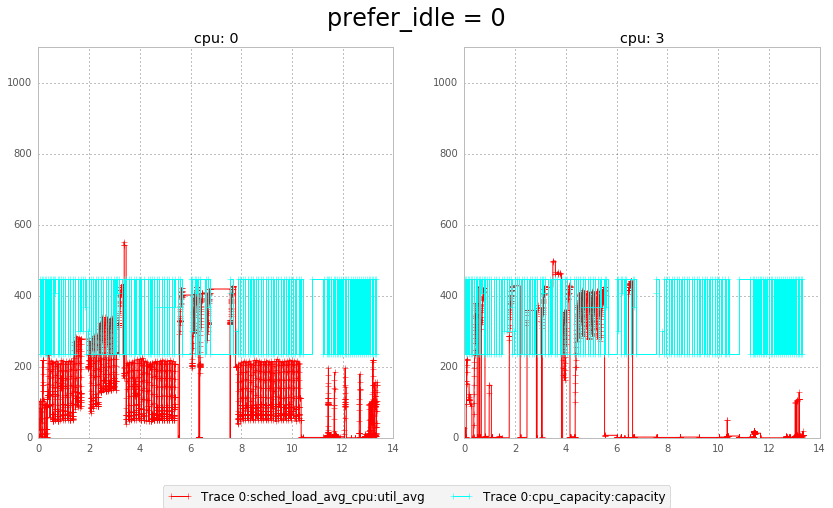

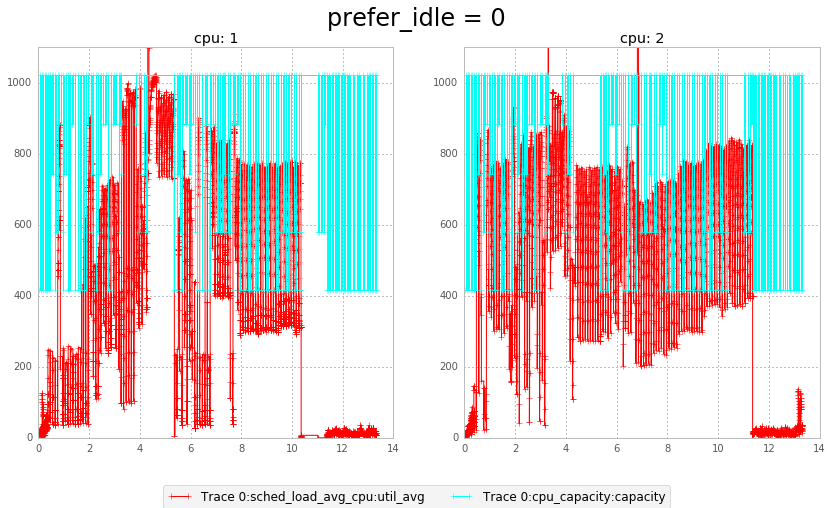

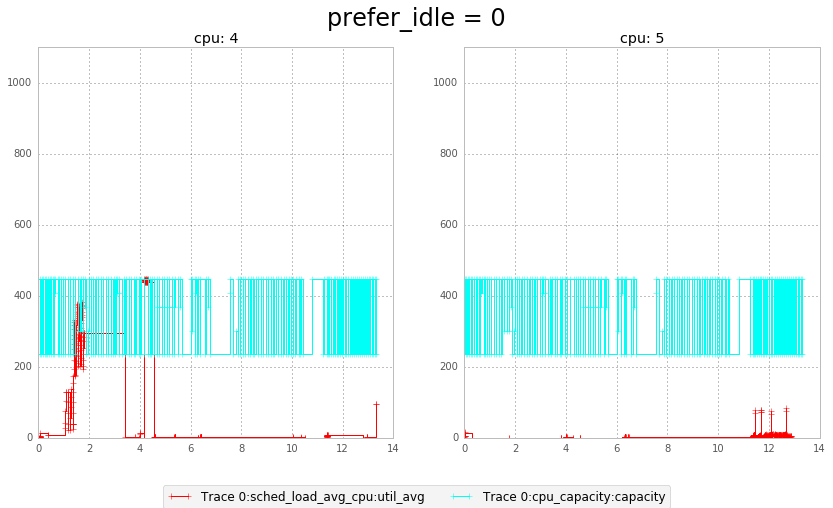

In [32]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
logging.info("ftrace object =%s", ftrace)
#trappy.ftrace.plotClusterFrequencies()


trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [0,3]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 0",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [1,2]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 0",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace,
    signals=[
    "sched_load_avg_cpu:util_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [4,5]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 0",
    ylim=(0, 1100)).view()

03:40:51  WARNING : Event [sched_overutilized] not found, plot DISABLED!
03:40:51  WARNING : Event [sched_overutilized] not found, plot DISABLED!
03:40:52  INFO    : LITTLE cluster average frequency: 0.750 GHz
03:40:52  INFO    : big    cluster average frequency: 1.028 GHz


(0.7501341644735704, 1.0277564290206578)

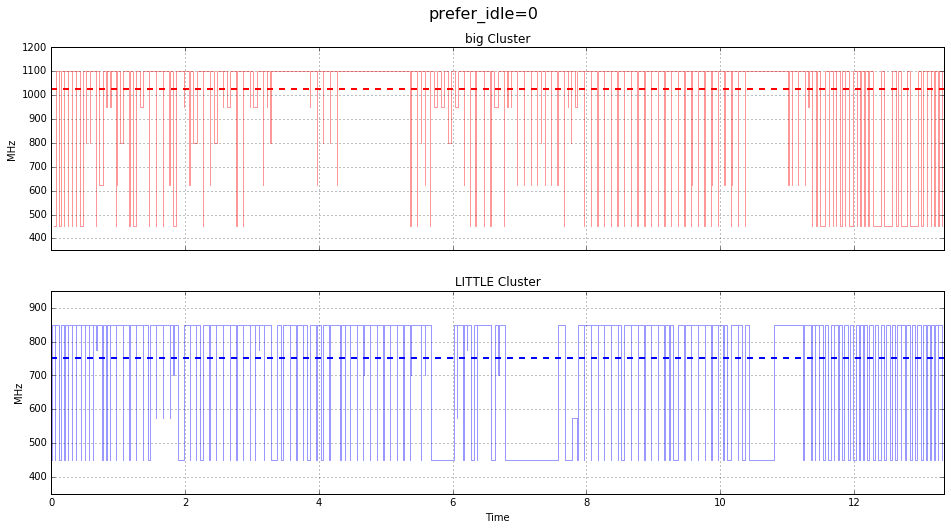

In [33]:
trace.analysis.frequency.plotClusterFrequencies("prefer_idle=0")

In [34]:
trace.data_frame.cpu_idle_state_residency(1)

,time
idle_state,
0,0.538379
1,0.431178
2,7.336782


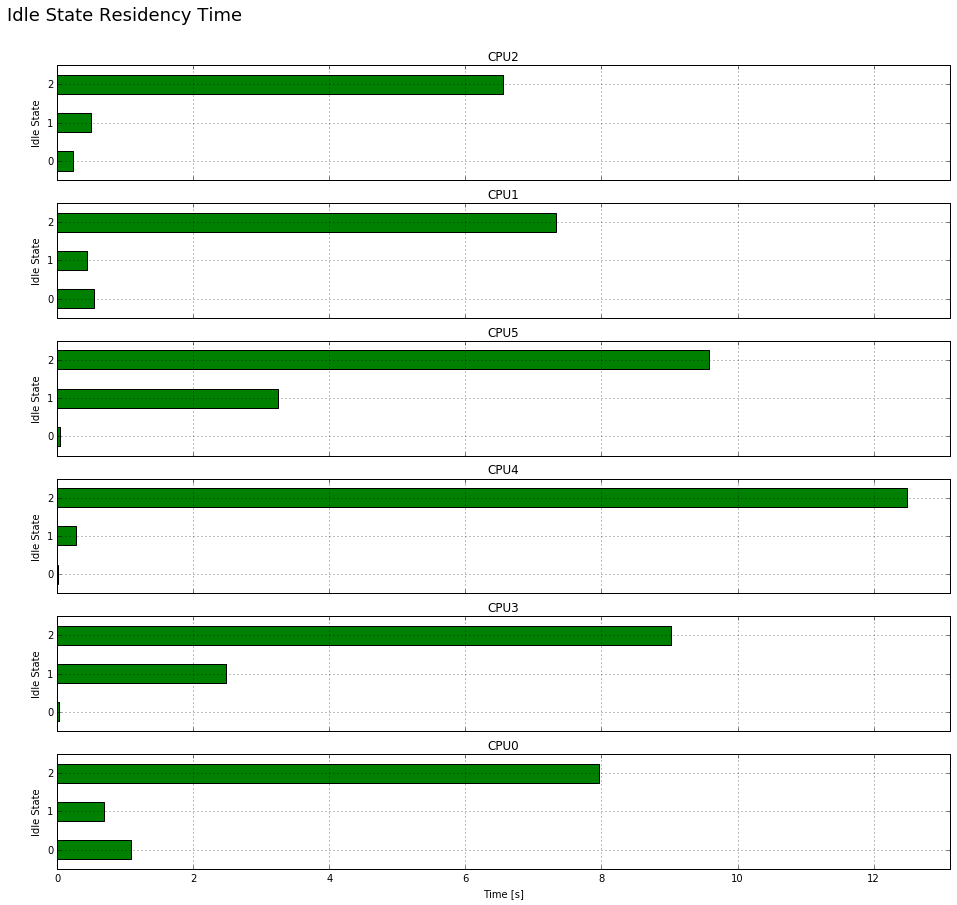

In [35]:
ia = trace.analysis.idle

# Actual time spent in each idle state
ia.plotCPUIdleStateResidency([0, 1,2, 3, 4, 5])

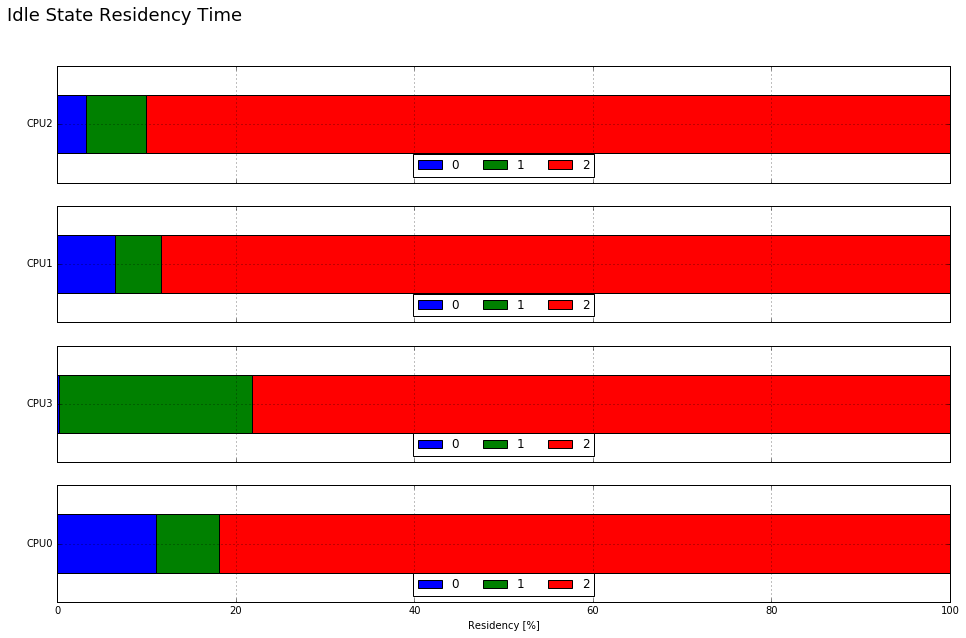

In [36]:
# Percentage of time spent in each idle state
ia.plotCPUIdleStateResidency([0,1,2,3], pct=True)

03:41:21  DEBUG   : Found rt-app logfile for task [ramp_1]
03:41:21  DEBUG   : Found rt-app logfile for task [ramp_2]
03:41:21  DEBUG   : Found rt-app logfile for task [ramp_2]
03:41:21  DEBUG   : Found rt-app logfile for task [period_1]
03:41:21  DEBUG   : Found rt-app logfile for task [ramp_1]
03:41:21  DEBUG   : Found rt-app logfile for task [task_2]
03:41:21  DEBUG   : Found rt-app logfile for task [period_2]
03:41:21  DEBUG   : Found rt-app logfile for task [ramp_1]
03:41:21  DEBUG   : Found rt-app logfile for task [task_2]
03:41:21  DEBUG   : Loading dataframe for task [period_2]...
03:41:21  DEBUG   : Loading dataframe for task [ramp_2]...
03:41:21  DEBUG   : Loading dataframe for task [ramp_1]...
03:41:21  DEBUG   : Loading dataframe for task [period_1]...
03:41:21  DEBUG   : Loading dataframe for task [task_2]...
03:41:21  INFO    : PerfIndex, Task [period_2] avg: 0.73, std: 0.37
03:41:22  INFO    : PerfIndex, Task [ramp_2] avg: 0.74, std: 0.28
03:41:23  INFO    : PerfIndex, T

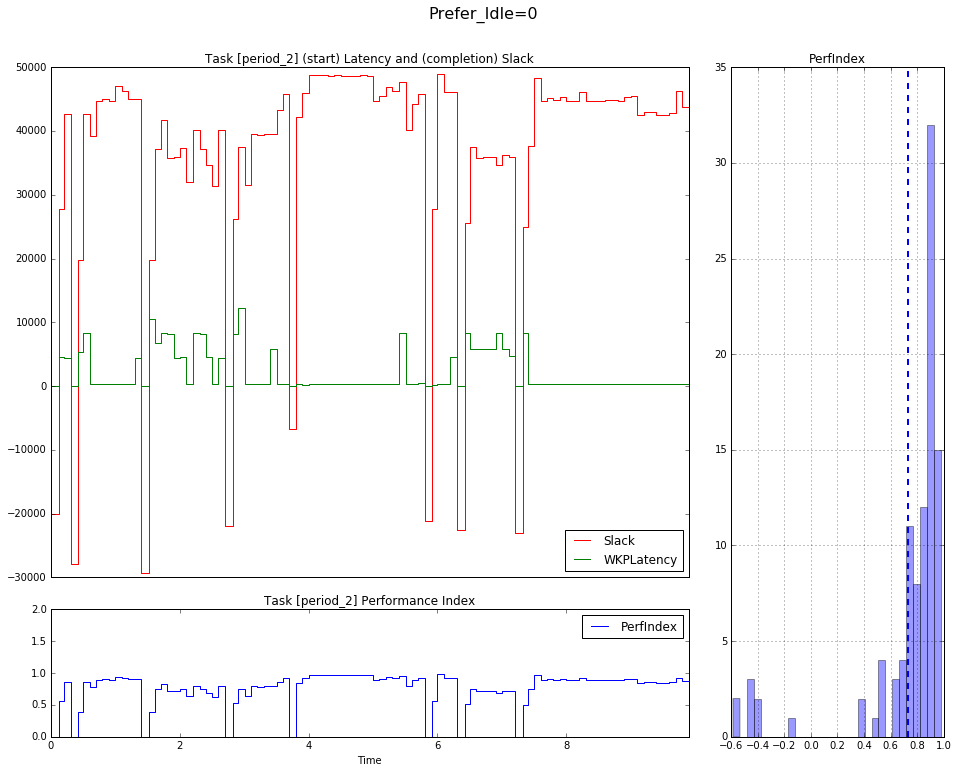

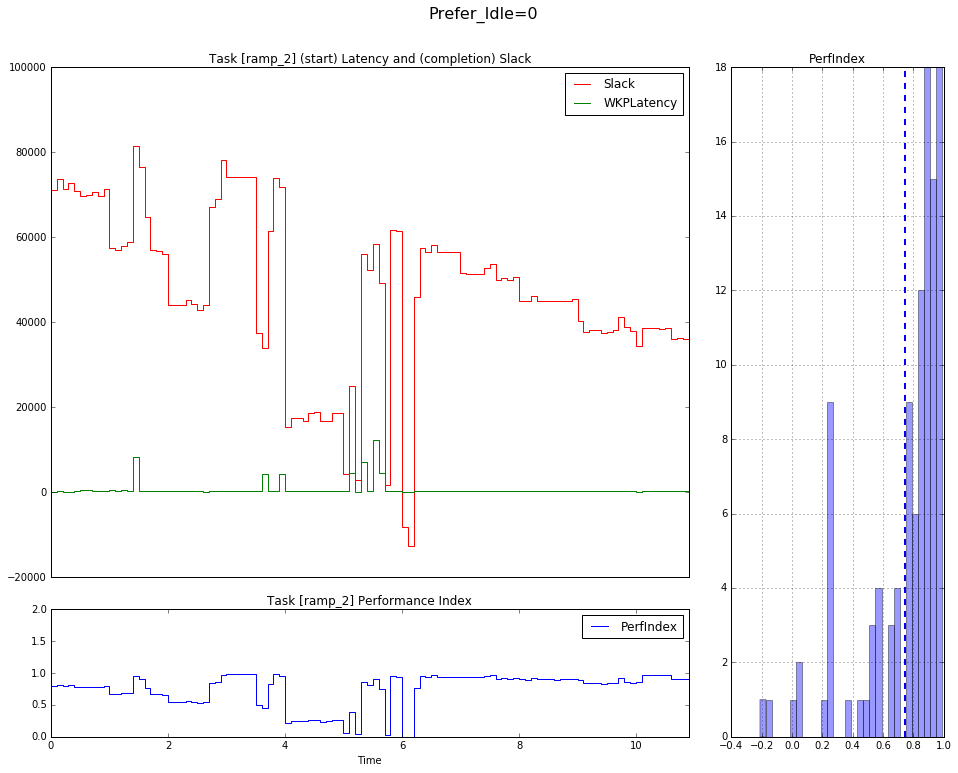

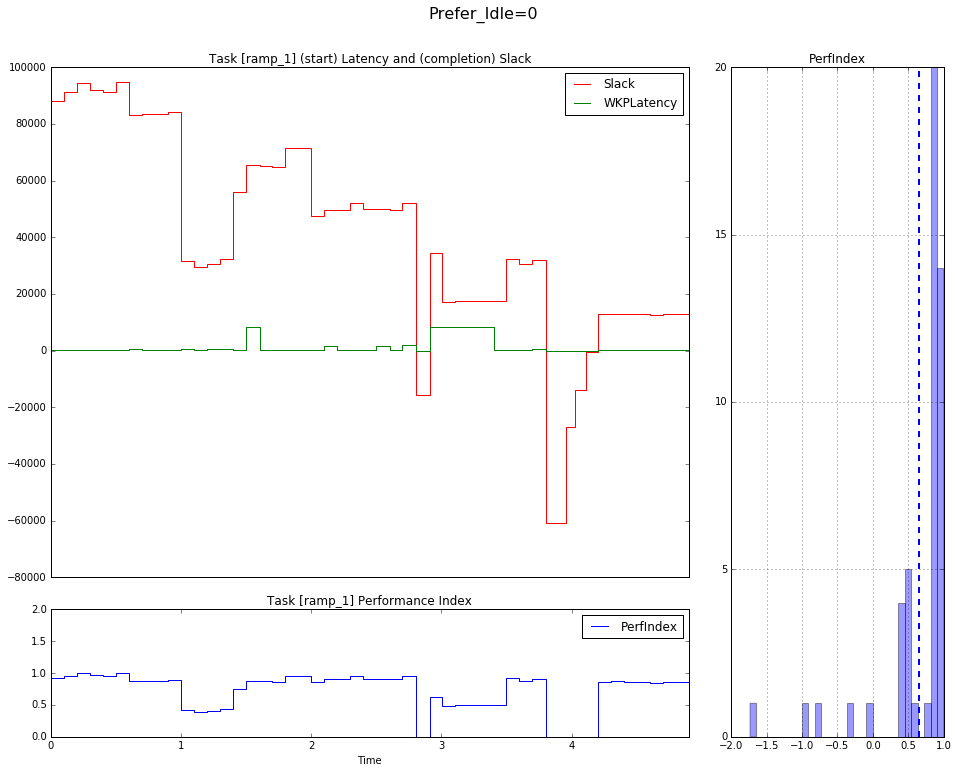

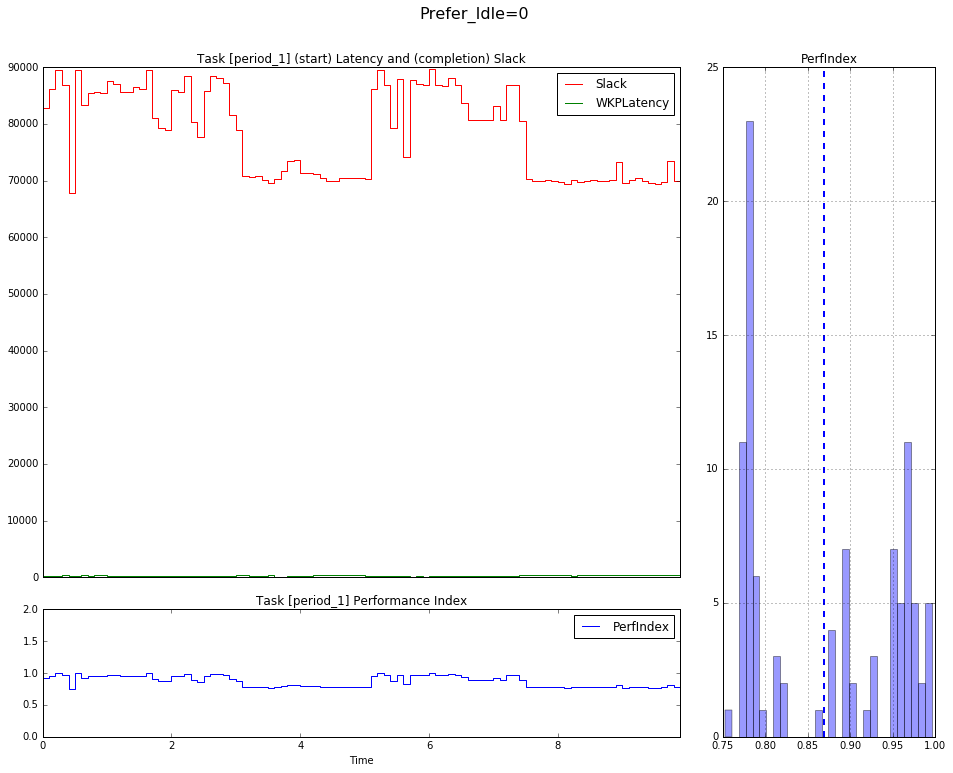

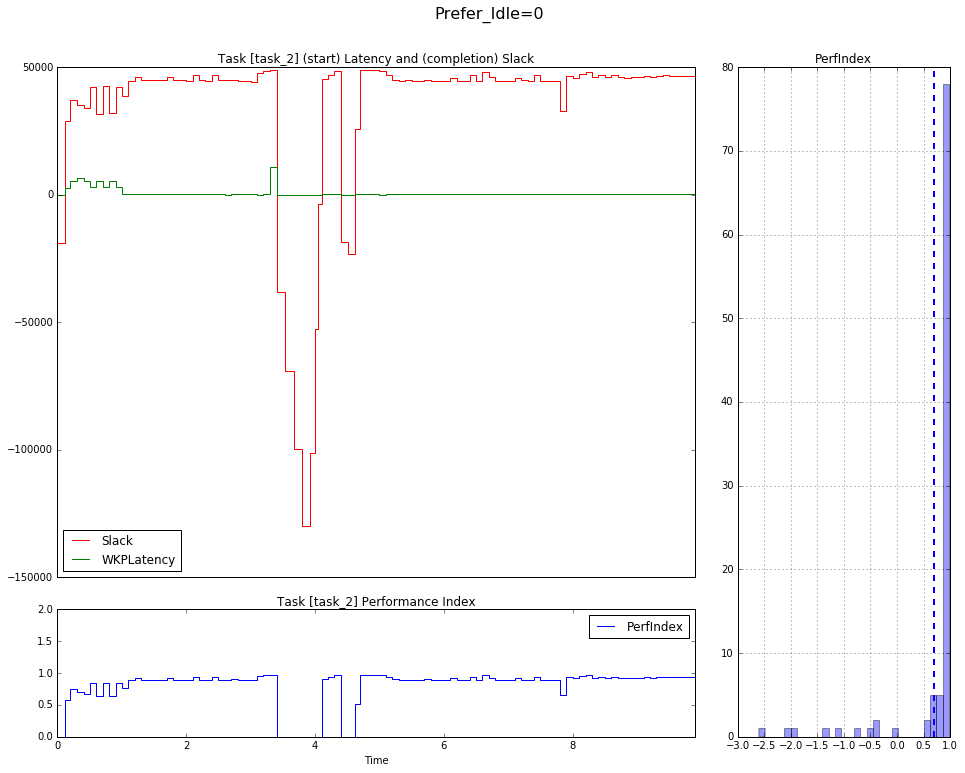

In [37]:
pa = PerfAnalysis( te.res_dir )

for task in pa.tasks():
    pa.plotPerf(task, "Prefer_Idle=0")

# schedtune.prefer_idle = 1

In [38]:
#
# configure prefer_idle
#
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))
#os.system("uname -a")
#target.execute("ls -al /dev/stune")
target.execute("echo 1 > /dev/stune/schedtune.prefer_idle")
logging.info("/dev/stune/schedtune.prefer_idle = %s",  target.read_value("/dev/stune/schedtune.prefer_idle"))

03:41:57  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/dev/stune/schedtune.prefer_idle'"
03:41:57  INFO    : /dev/stune/schedtune.prefer_idle = 0
03:41:57  DEBUG   : adb -s 10.169.36.25:5555 shell "echo 1 > /dev/stune/schedtune.prefer_idle"
03:41:57  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/dev/stune/schedtune.prefer_idle'"
03:41:57  INFO    : /dev/stune/schedtune.prefer_idle = 1


In [39]:
logging.info('#### Setup FTrace')
te.ftrace.start()

logging.info('#### Start energy sampling')
te.emeter.reset()

logging.info('#### Start RTApp execution')
rtapp.run(out_dir=te.res_dir, cgroup="")

logging.info('#### Read energy consumption: %s/energy.json', te.res_dir)
(nrg, nrg_file) = te.emeter.report(out_dir=te.res_dir)

logging.info('#### Stop FTrace')
te.ftrace.stop()

trace_file = os.path.join(te.res_dir, 'trace.dat')
logging.info('#### Save FTrace: %s', trace_file)
te.ftrace.get_trace(trace_file)

logging.info('#### Save platform description: %s/platform.json', te.res_dir)
(plt, plt_file) = te.platform_dump(te.res_dir)

03:42:05  INFO    : #### Setup FTrace
03:42:05  DEBUG   : adb -s 10.169.36.25:5555 shell "echo 'echo 10240 > '\\''/sys/kernel/debug/tracing/buffer_size_kb'\\''' | su"
03:42:05  DEBUG   : adb -s 10.169.36.25:5555 shell "cat '/sys/kernel/debug/tracing/buffer_size_kb'"
03:42:05  DEBUG   : adb -s 10.169.36.25:5555 shell "echo '/data/local/tmp/bin/trace-cmd reset' | su"
03:42:06  DEBUG   : adb -s 10.169.36.25:5555 shell "echo '/data/local/tmp/bin/trace-cmd start -e cpu_frequency -e sched_load_avg_cpu -e sched_load_avg_task -e sched_switch -e cpu_capacity -e cpu_idle -e sched_blocked_reason -e sched_boost_cpu -e sched_boost_task -e sched_contrib_scale_f -e sched_cpu_hotplug -e sched_energy_diff -e sched_kthread_stop -e sched_kthread_stop_ret -e sched_load_avg_cpu -e sched_load_avg_task -e sched_migrate_task -e sched_move_numa -e sched_pi_setprio -e sched_process_exec -e sched_process_exit -e sched_process_fork -e sched_process_free -e sched_process_wait -e sched_stat_blocked -e sched_stat_io

# Trace Analysis

In [40]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(te.res_dir)

In [41]:
events_to_parse = my_tests_conf['ftrace']['events']

trace2 = Trace(plt, te.res_dir, events_to_parse)

ftrace2 = trace2.ftrace

trappy.plotter.plot_trace(ftrace2, execnames=['period_1', "period_2", 
                                             "ramp_1", "ramp_2",                                             ])

03:42:30  DEBUG   : Loading [sched] events from trace in [/data/lisa_fork/lisa/results/prefer_idle]...
03:42:30  DEBUG   : Parsing events: ['cpu_frequency', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_switch', 'dequeue_task_fair', 'enqueue_task_fair', 'set_next_entity', 'cpu_capacity', 'cpu_idle', 'sched_blocked_reason', 'sched_boost_cpu', 'sched_boost_task', 'sched_contrib_scale_f', 'sched_cpu_hotplug', 'sched_energy_diff', 'sched_kthread_stop', 'sched_kthread_stop_ret', 'sched_load_avg_cpu', 'sched_load_avg_task', 'sched_migrate_task', 'sched_move_numa', 'sched_pi_setprio', 'sched_process_exec', 'sched_process_exit', 'sched_process_fork', 'sched_process_free', 'sched_process_wait', 'sched_stat_blocked', 'sched_stat_iowait', 'sched_stat_runtime', 'sched_stat_sleep', 'sched_stat_wait', 'sched_stick_numa', 'sched_swap_numa', 'sched_switch', 'sched_tune_boostgroup_update', 'sched_tune_config', 'sched_tune_tasks_update', 'sched_tune_filter', 'sched_wait_task', 'sched_wake_idle_wit

03:42:35  INFO    : ftrace object =<trappy.ftrace.FTrace object at 0x7fc9efff1bd0>


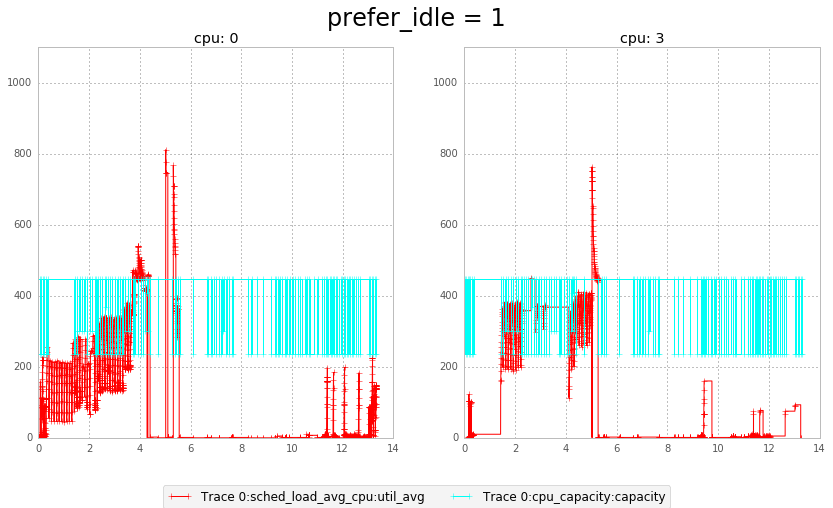

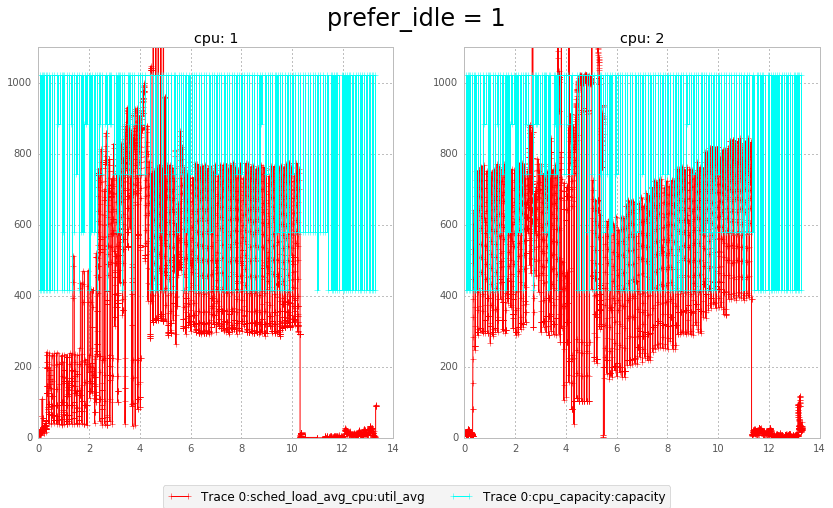

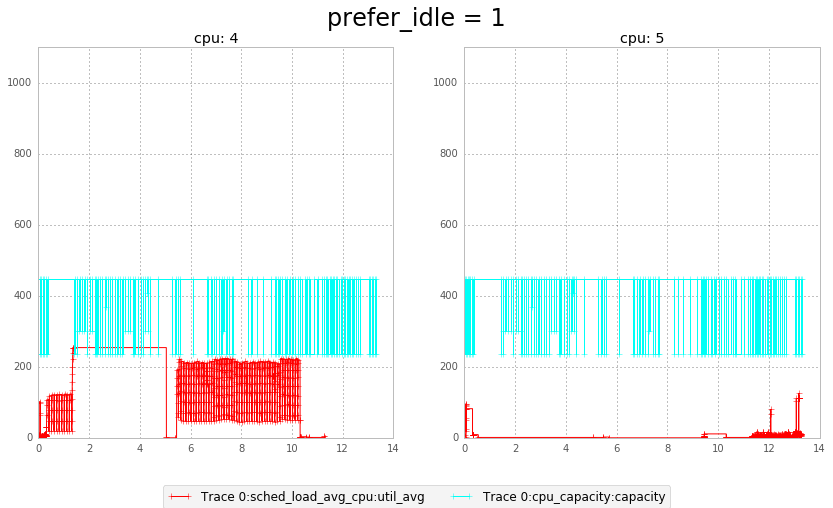

In [42]:
# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
logging.info("ftrace object =%s", ftrace2)
#trappy.ftrace.plotClusterFrequencies()


trappy.LinePlot(ftrace2,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [0,3]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 1",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace2,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [1,2]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 1",
    ylim=(0, 1100)).view()
trappy.LinePlot(ftrace2,
    signals=[
    "sched_load_avg_cpu:util_avg",
    #"sched_load_avg_cpu:load_avg",
    "cpu_capacity:capacity"],
    pivot="cpu",
    filters={"cpu": [4,5]},
    marker = '+',
    drawstyle='steps-post',
    title="prefer_idle = 1",
    ylim=(0, 1100)).view()

03:42:37  WARNING : Event [sched_overutilized] not found, plot DISABLED!
03:42:37  WARNING : Event [sched_overutilized] not found, plot DISABLED!
03:42:38  INFO    : LITTLE cluster average frequency: 0.813 GHz
03:42:38  INFO    : big    cluster average frequency: 1.016 GHz


(0.81291125473746095, 1.0155345231589932)

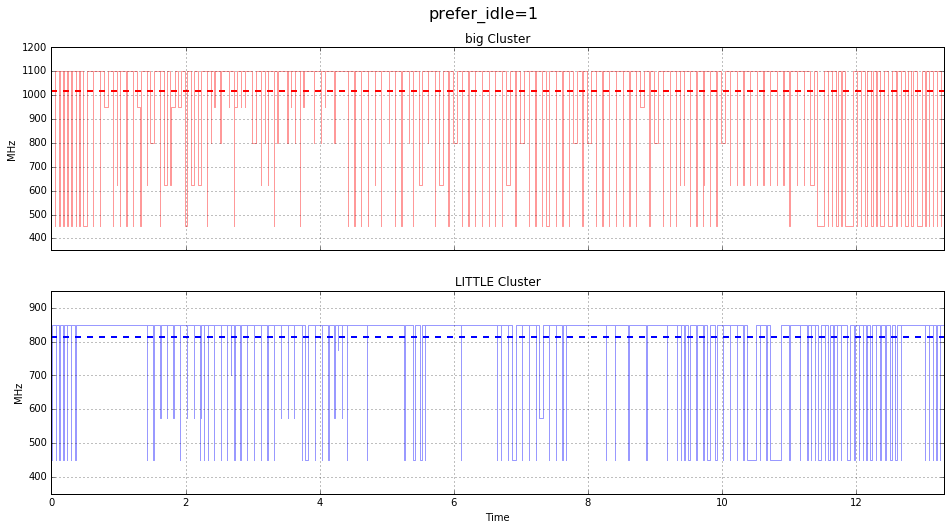

In [43]:
trace2.analysis.frequency.plotClusterFrequencies("prefer_idle=1")


In [44]:
trace2.data_frame.cpu_idle_state_residency(2)

,time
idle_state,
0,0.178767
1,0.774844
2,6.108044


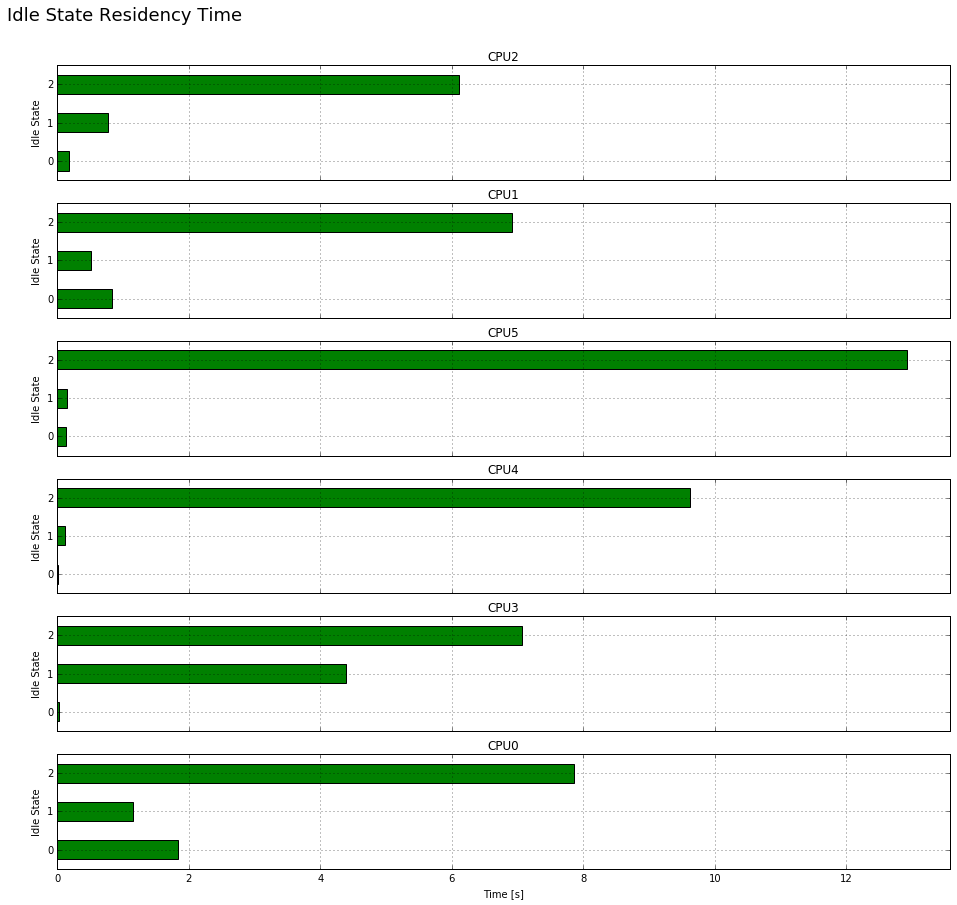

In [45]:
ia_2 = trace2.analysis.idle

# Actual time spent in each idle state
ia_2.plotCPUIdleStateResidency([0, 1,2, 3, 4, 5])

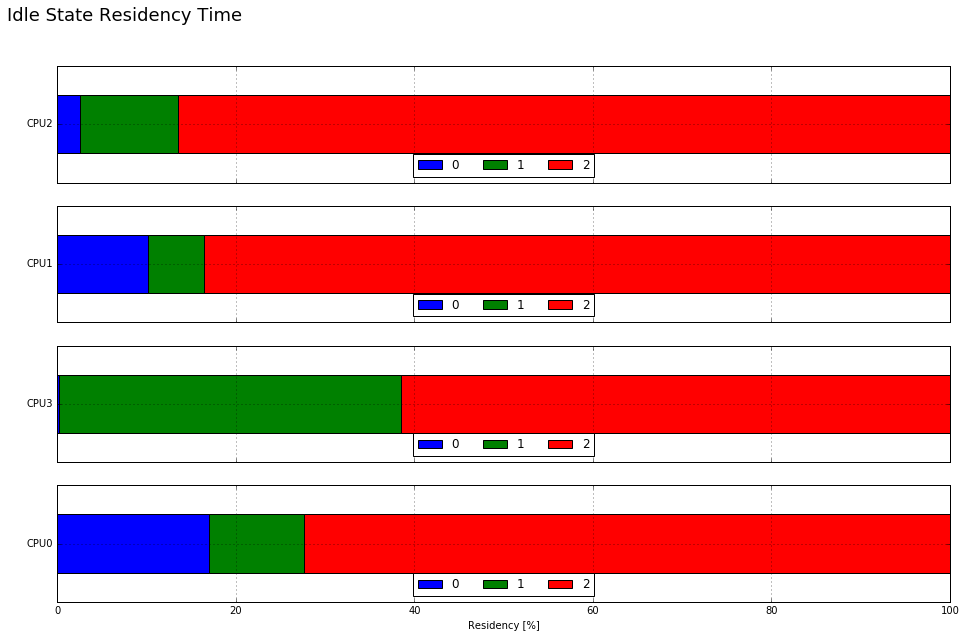

In [46]:
# Percentage of time spent in each idle state
ia_2.plotCPUIdleStateResidency([0,1,2,3], pct=True)

03:42:56  DEBUG   : Found rt-app logfile for task [ramp_1]
03:42:56  DEBUG   : Found rt-app logfile for task [ramp_2]
03:42:56  DEBUG   : Found rt-app logfile for task [ramp_2]
03:42:56  DEBUG   : Found rt-app logfile for task [period_1]
03:42:56  DEBUG   : Found rt-app logfile for task [ramp_1]
03:42:56  DEBUG   : Found rt-app logfile for task [task_2]
03:42:56  DEBUG   : Found rt-app logfile for task [period_2]
03:42:56  DEBUG   : Found rt-app logfile for task [ramp_1]
03:42:56  DEBUG   : Found rt-app logfile for task [task_2]
03:42:56  DEBUG   : Loading dataframe for task [period_2]...
03:42:56  DEBUG   : Loading dataframe for task [ramp_2]...
03:42:56  DEBUG   : Loading dataframe for task [ramp_1]...
03:42:56  DEBUG   : Loading dataframe for task [period_1]...
03:42:56  DEBUG   : Loading dataframe for task [task_2]...
03:42:57  INFO    : PerfIndex, Task [period_2] avg: 0.83, std: 0.25
03:42:58  INFO    : PerfIndex, Task [ramp_2] avg: 0.78, std: 0.19
03:42:59  INFO    : PerfIndex, T

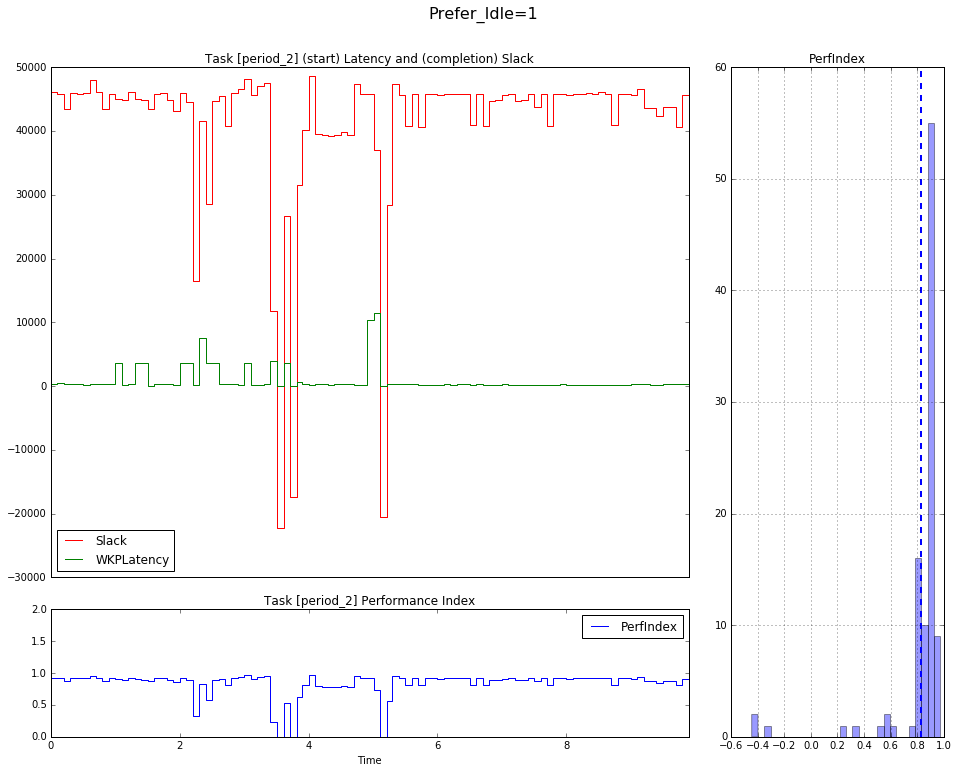

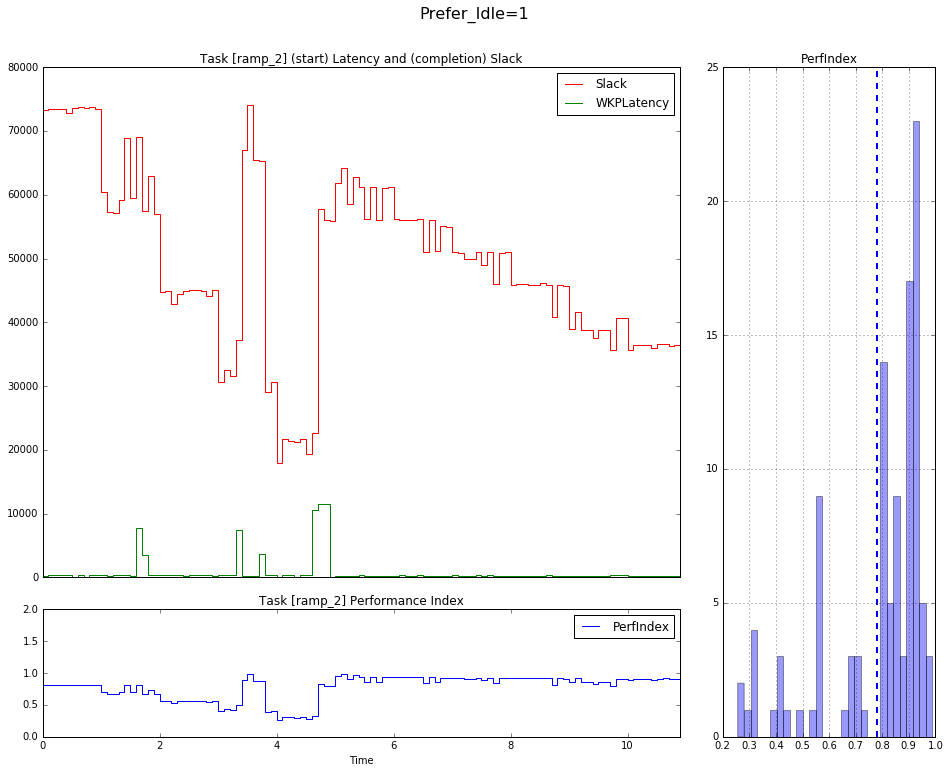

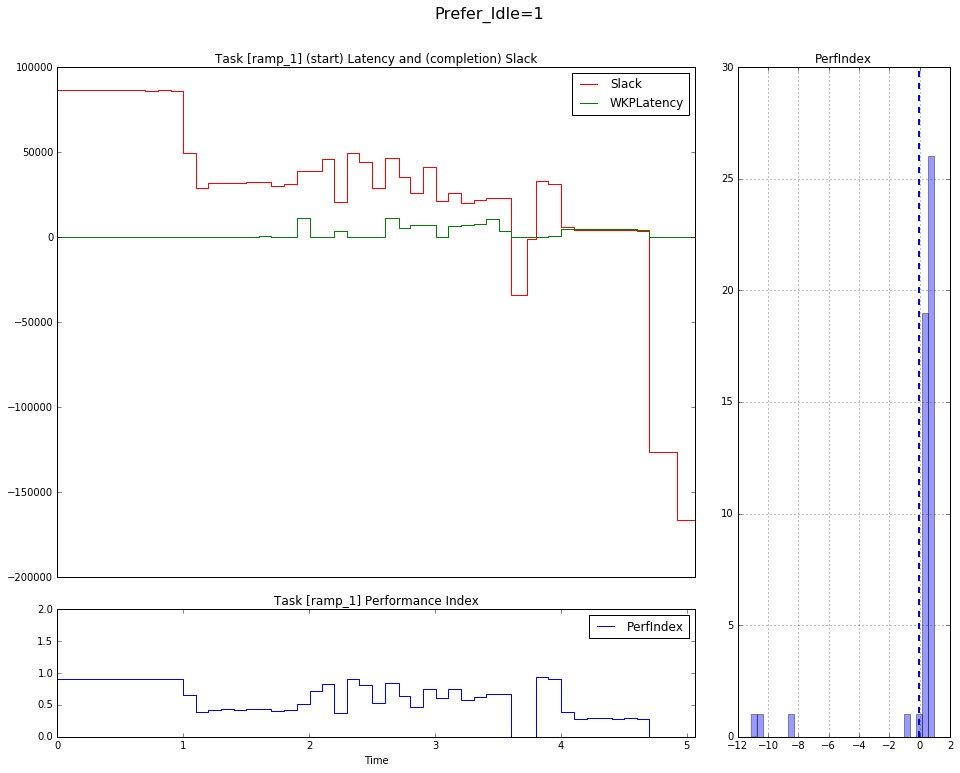

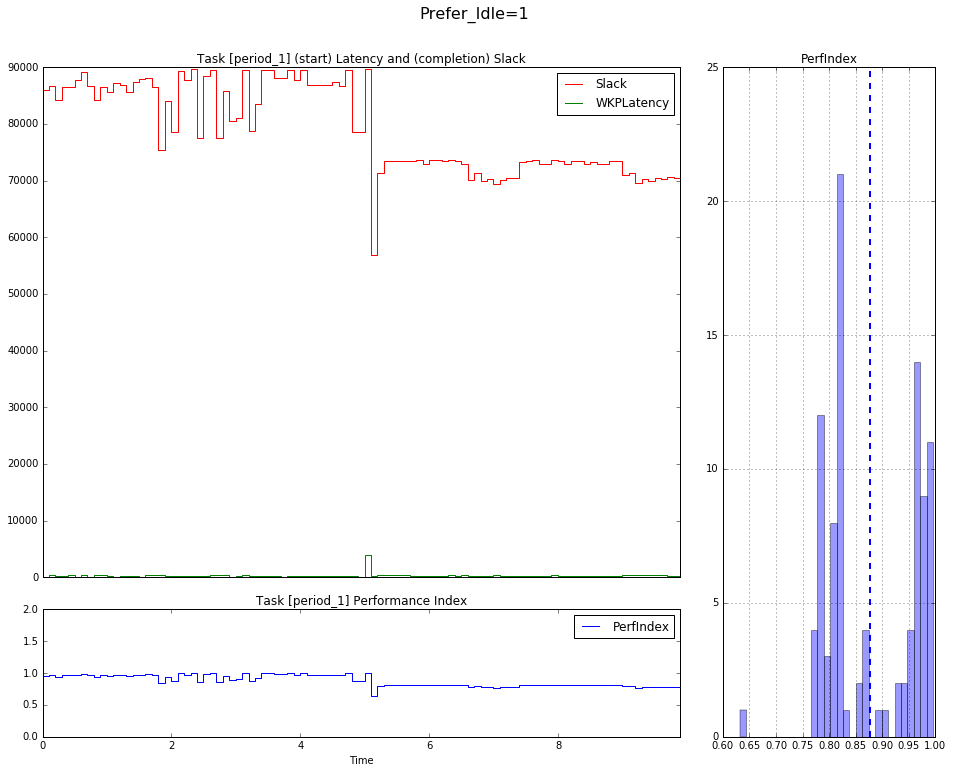

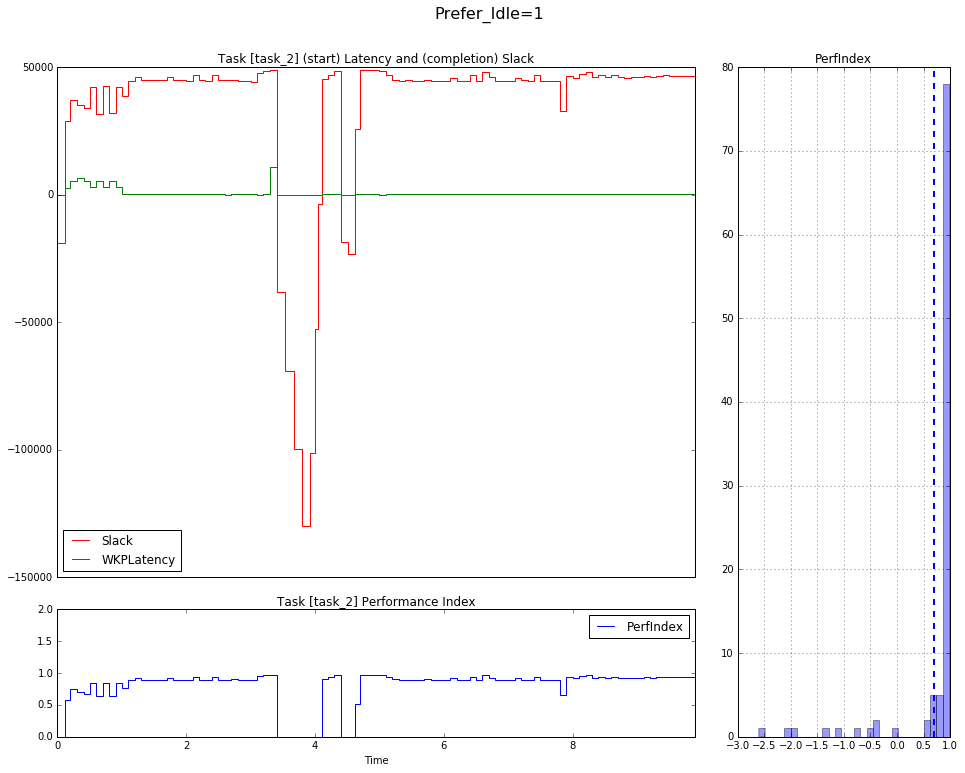

In [47]:
pa_2 = PerfAnalysis( te.res_dir )

for task in pa_2.tasks():
    pa_2.plotPerf(task, "Prefer_Idle=1")